<a href="https://colab.research.google.com/github/saritmaitra/AL-VAR-VECM-/blob/main/ARCH_volatility_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Volatility modelling

## Testing for ARCH effects in exchange rate returns

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt 
import datetime as dt
import seaborn as sns
%matplotlib inline
from statsmodels.stats.diagnostic import het_arch
from statsmodels.compat import lzip
import statsmodels.api as sm
import pandas.util.testing as tm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
from google.colab import files
uploaded = files.upload()

Saving AL_final_data.csv to AL_final_data.csv


In [4]:
# Import Gold data in panda and passed to a variable name "df1"
data = pd.read_csv("AL_final_data.csv")
data.drop(['Unnamed: 0'], axis=1, inplace=True)
data.tail()

,timestamp,es,eur_usd,gbp_usd,gc,nq,usd_jpy
29340,2020-05-29 20:56:00,3027.25,1111740.0,1235400.0,1731.50,9588.625,107675000.0
29341,2020-05-29 20:57:00,3027.25,1111750.0,1235450.0,1731.20,9588.500,107830000.0
29342,2020-05-29 20:58:00,3027.25,1111650.0,1235450.0,1731.45,9588.625,107830000.0
29343,2020-05-29 20:59:00,3027.25,1113400.0,1235450.0,1731.30,9587.375,107835000.0
29344,2020-05-29 21:00:00,3027.25,1113400.0,1237150.0,1731.35,9591.125,107835000.0


In [5]:
data = data.set_index('timestamp')
data

,es,eur_usd,gbp_usd,gc,nq,usd_jpy
timestamp,,,,,,
2020-05-01 00:00:00,2877.125,1094465.0,1258140.0,1695.85,8846.125,107301000.0
2020-05-01 00:01:00,2875.375,1094215.0,1257935.0,1695.60,8841.250,107368000.0
2020-05-01 00:02:00,2874.625,1094165.0,1257765.0,1695.65,8837.750,107376500.0
2020-05-01 00:03:00,2874.125,1094115.0,1257565.0,1695.40,8836.750,107381500.0
2020-05-01 00:04:00,2875.250,1094190.0,1257535.0,1694.85,8841.125,107376500.0
...,...,...,...,...,...,...
2020-05-29 20:56:00,3027.250,1111740.0,1235400.0,1731.50,9588.625,107675000.0
2020-05-29 20:57:00,3027.250,1111750.0,1235450.0,1731.20,9588.500,107830000.0
2020-05-29 20:58:00,3027.250,1111650.0,1235450.0,1731.45,9588.625,107830000.0


In [6]:
# Converting the index as date
data.index = pd.to_datetime(data.index)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 29345 entries, 2020-05-01 00:00:00 to 2020-05-29 21:00:00
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   es       29345 non-null  float64
 1   eur_usd  29345 non-null  float64
 2   gbp_usd  29345 non-null  float64
 3   gc       29345 non-null  float64
 4   nq       29345 non-null  float64
 5   usd_jpy  29345 non-null  float64
dtypes: float64(6)
memory usage: 1.6 MB


In [7]:
data = data.resample('B').ffill().bfill()
data.tail()

,es,eur_usd,gbp_usd,gc,nq,usd_jpy
timestamp,,,,,,
2020-05-25,2967.875,1090835.0,1218635.0,1730.35,9460.000,107750500.0
2020-05-26,2982.125,1090080.0,1220010.0,1727.10,9508.875,107692000.0
2020-05-27,2993.125,1097845.0,1233230.0,1704.75,9404.625,107489500.0
2020-05-28,3041.375,1101505.0,1226240.0,1708.30,9439.500,107805500.0
2020-05-29,3024.750,1107780.0,1231910.0,1721.40,9416.625,107630500.0


In [8]:
data.isnull().sum()

es         0
eur_usd    0
gbp_usd    0
gc         0
nq         0
usd_jpy    0
dtype: int64

In [9]:
# Calculate daily returns:
returns = 100 * data.pct_change().dropna()
returns

,es,eur_usd,gbp_usd,gc,nq,usd_jpy
timestamp,,,,,,
2020-05-04,-3.406178,0.111470,-1.004658,0.686971,-2.917944,-0.506519
2020-05-05,1.911573,-0.477783,-0.061020,0.248902,2.782953,-0.069316
2020-05-06,1.151911,-0.596084,-0.020085,0.046736,1.400532,-0.240431
2020-05-07,-0.999171,-0.366253,-0.957019,-1.185367,0.251379,-0.210003
2020-05-08,2.137506,0.336580,0.378069,1.926429,2.035244,0.180314
2020-05-11,1.372168,0.003691,0.343507,-0.959504,1.026677,0.485455
2020-05-12,-0.664028,-0.261615,-0.670565,-0.523913,0.325684,0.642588
2020-05-13,-2.888118,0.351122,-0.635357,0.432518,-2.765393,-0.401028
2020-05-14,-0.697172,-0.223582,-0.118744,1.204078,-0.272906,-0.246811


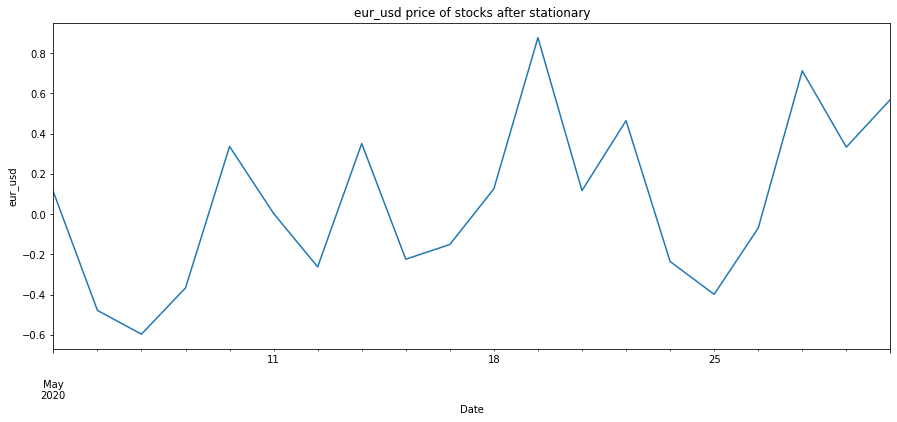

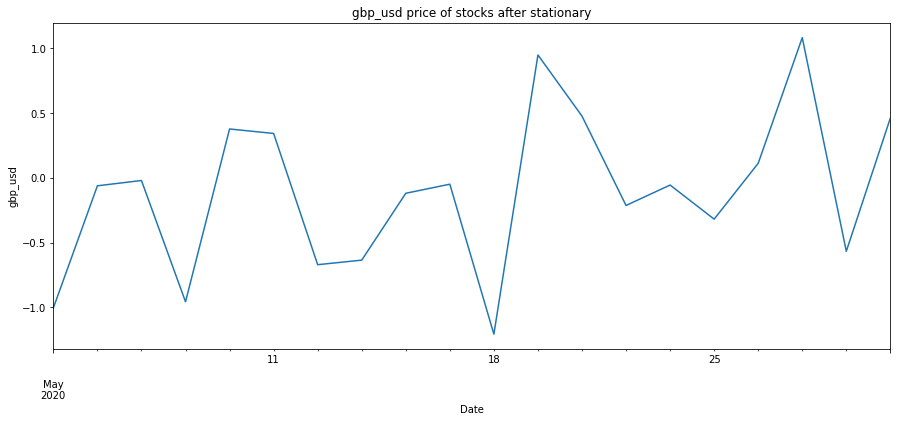

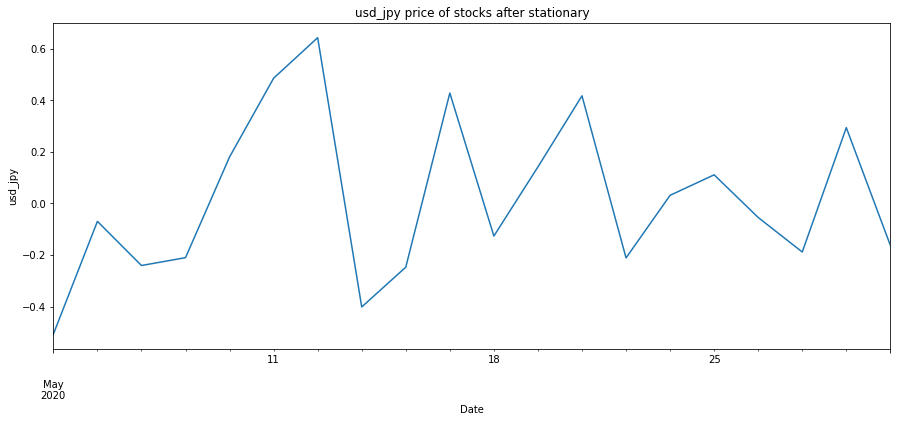

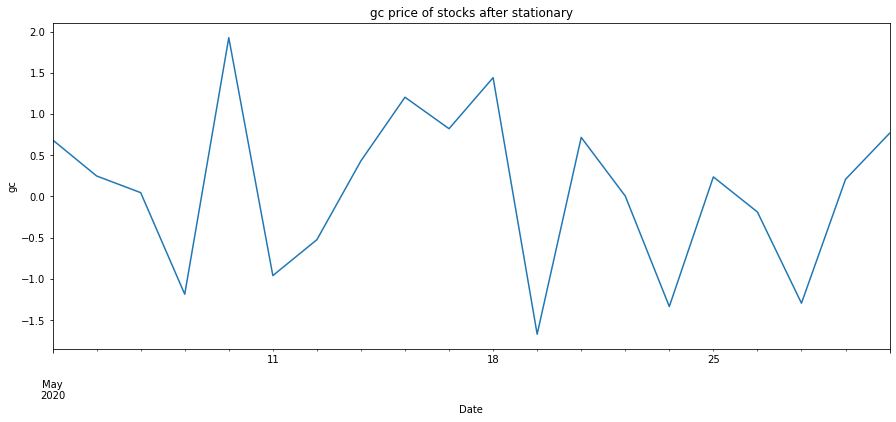

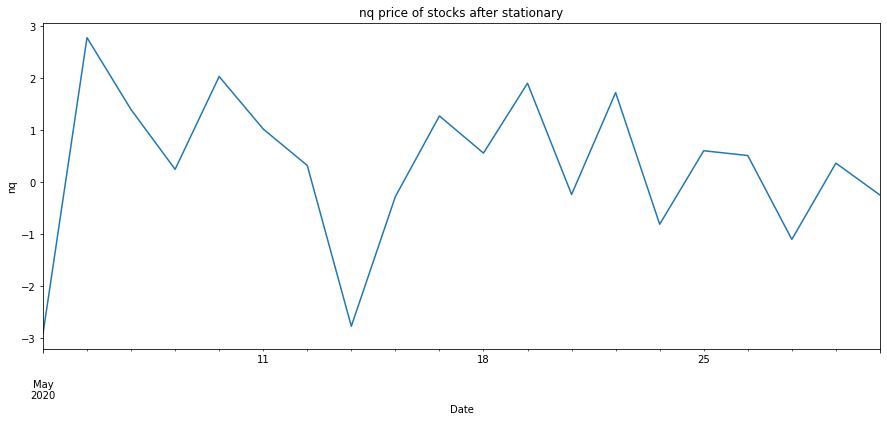

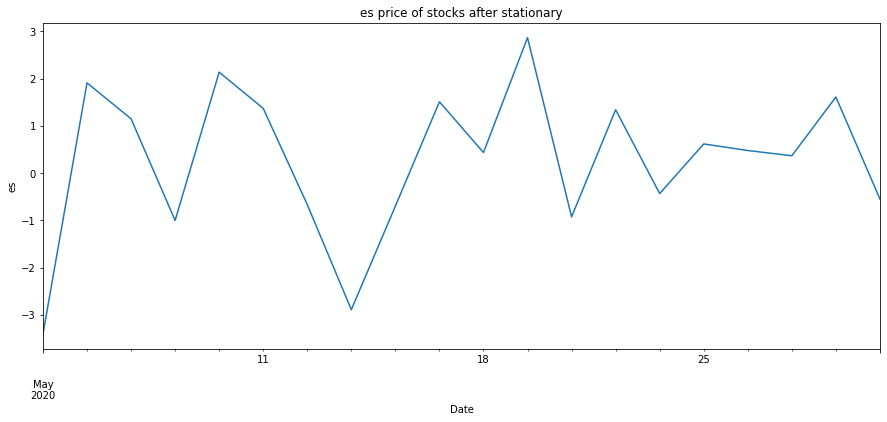

In [10]:
for c in returns[['eur_usd','gbp_usd','usd_jpy','gc','nq','es']]:
    returns[str(c)].plot(figsize=(15, 6))
    plt.xlabel("Date")
    plt.ylabel(c)
    plt.title(f"{str(c)} price of stocks after stationary")
    plt.show()

In the plots, we can observe a few sudden spikes and examples of volatility clustering.

In [11]:
!pip install arch
from arch import arch_model

     |████████████████████████████████| 798kB 4.8MB/s 


# CCC-GARCH model for multivariate volatility forecasting

In [12]:
# lists for storing objects:
coeffs = []
cond_vol = []
std_resids = []
models = []

In [13]:
# Estimate the univariate GARCH models:
for asset in returns.columns:
  model = arch_model(returns['eur_usd'], mean='Constant', vol='GARCH', p=1, o=0,
                     q=1).fit(update_freq=0, disp='off')
  coeffs.append(model.params)
  cond_vol.append(model.conditional_volatility)
  std_resids.append(model.resid / model.conditional_volatility)
  models.append(model)

In [14]:
# Store the results in DataFrames:
coeffs_df = pd.DataFrame(coeffs, index=returns.columns)
cond_vol_df = pd.DataFrame(cond_vol).transpose().set_axis(returns.columns, axis='columns', inplace=False)
std_resids_df = pd.DataFrame(std_resids).transpose().set_axis(returns.columns, axis='columns', inplace=False)

In [15]:
# table containing the estimated coefficients for each series:
coeffs_df

,mu,omega,alpha[1],beta[1]
es,0.061194,0.109859,0.0,0.321801
eur_usd,0.061194,0.109859,0.0,0.321801
gbp_usd,0.061194,0.109859,0.0,0.321801
gc,0.061194,0.109859,0.0,0.321801
nq,0.061194,0.109859,0.0,0.321801
usd_jpy,0.061194,0.109859,0.0,0.321801


In [16]:
# constant conditional correlation matrix (R):
R = std_resids_df.transpose().dot(std_resids_df).div(len(std_resids_df))

# one-step-ahead forecast of the conditional covariance matrix:
diag = []
n = (6)
D = np.zeros((n,n))
for model in models:
  diag.append(model.forecast(horizon=1).variance.values[-1][0])
diag = np.sqrt(np.array(diag))
np.fill_diagonal(D, diag)
H = np.matmul(np.matmul(D, R.values), D)

In [17]:
pd.DataFrame(H, columns = returns.columns)

,es,eur_usd,gbp_usd,gc,nq,usd_jpy
0,0.160543,0.160543,0.160543,0.160543,0.160543,0.160543
1,0.160543,0.160543,0.160543,0.160543,0.160543,0.160543
2,0.160543,0.160543,0.160543,0.160543,0.160543,0.160543
3,0.160543,0.160543,0.160543,0.160543,0.160543,0.160543
4,0.160543,0.160543,0.160543,0.160543,0.160543,0.160543
5,0.160543,0.160543,0.160543,0.160543,0.160543,0.160543


In [24]:
X = returns[['gbp_usd']]

# split into train/test
nobs = 10
train, test = X[:-nobs], X[-nobs:]

In [28]:
model = arch_model(train, mean='Zero', vol='GARCH', p=12, q=12)

"""
mean='Zero'. 
model for the variance: vol='GARCH'. 
lag parameter for the GARCH model: p=12, q=12
"""
results = model.fit()
print(results.summary())

Iteration:      1,   Func. Count:     27,   Neg. LLF: 8.261043238478138
Iteration:      2,   Func. Count:     55,   Neg. LLF: 8.022803218345452
Iteration:      3,   Func. Count:     83,   Neg. LLF: 7.902723543355432
Iteration:      4,   Func. Count:    110,   Neg. LLF: 6.94122203340787
Iteration:      5,   Func. Count:    138,   Neg. LLF: 6.8187029275399045
Iteration:      6,   Func. Count:    165,   Neg. LLF: 6.363693306637218
Iteration:      7,   Func. Count:    193,   Neg. LLF: 6.34515788530463
Iteration:      8,   Func. Count:    221,   Neg. LLF: 6.320741706856615
Iteration:      9,   Func. Count:    249,   Neg. LLF: 6.293233690810988
Iteration:     10,   Func. Count:    277,   Neg. LLF: 6.265995433153545
Iteration:     11,   Func. Count:    305,   Neg. LLF: 6.240269559100694
Iteration:     12,   Func. Count:    332,   Neg. LLF: 6.0309423563720665
Iteration:     13,   Func. Count:    365,   Neg. LLF: 6.021350048529576
Iteration:     14,   Func. Count:    393,   Neg. LLF: 5.75647636

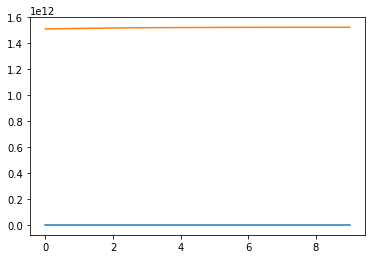

In [32]:
# forecast the test set
yhat = model_fit.forecast(horizon=nobs)
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-nobs:])
# plot forecast variance
plt.plot(yhat.variance.values[-1, :])
plt.show()

Ref: https://vlab.stern.nyu.edu/docs/correlation/GARCH-DCC

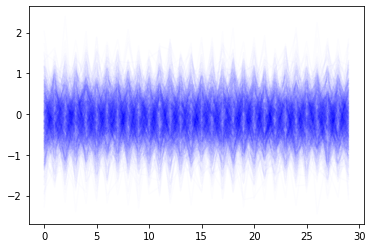

In [20]:
forecasts = results.forecast(horizon=30, method='simulation', simulations=1000)
sims = forecasts.simulations

lines = plt.plot(sims.values[-1,:,:].T, color='blue', alpha=0.01)
lines[0].set_label('Simulated paths')
plt.show()

-1.0427653021266803


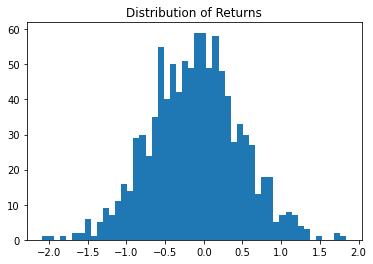

In [21]:
print(np.percentile(sims.values[-1,:,-1].T,5))
plt.hist(sims.values[-1, :,-1],bins=50)
plt.title('Distribution of Returns')
plt.show()

In [ ]:
!pip install pmdarima
import pmdarima
import arch

# fit ARIMA on returns 
arima_model_fitted = pmdarima.auto_arima(train)
p, d, q = arima_model.order
arima_residuals = arima_model.arima_res_.resid

# fit a GARCH(1,1) model on the residuals of the ARIMA model
garch = arch.arch_model(arima_residuals, p=1, q=1)
garch_fitted = garch.fit()

# Use ARIMA to predict mu
predicted_mu = arima_model.predict(n_periods=1)[0]
# Use GARCH to predict the residual
garch_forecast = garch_model.forecast(horizon=1)
predicted_et = garch_forecast.mean['h.1'].iloc[-1]
# Combine both models' output: yt = mu + et
prediction = predicted_mu + predicted_et